In [1]:
from sklearn.datasets import fetch_california_housing 
from sklearn.preprocessing import StandardScaler
data = fetch_california_housing()
print(data.feature_names) 
X, y = data.data, data.target
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split 
# train-test split of the dataset
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
label_scaler = StandardScaler()
label_scaler.fit(y_train.reshape(-1, 1))
y_train = label_scaler.transform(y_train.reshape(-1, 1))
y_test = label_scaler.transform(y_test.reshape(-1, 1))


['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [3]:
class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().reshape(-1, 1)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)

In [4]:
training_data = HousingDataset(X_train, y_train)
test_data = HousingDataset(X_test, y_test)

train_loader = DataLoader(training_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)


In [5]:
class HousingNet(torch.nn.Module):
    def __init__(self, n_features):
        super(HousingNet, self).__init__()
        self.fc1 = torch.nn.Linear(n_features, 64)
        self.fc2 = torch.nn.Linear(64, 256)
        self.fc3 = torch.nn.Linear(256, 64)
        self.fc4 = torch.nn.Linear(64, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x)) 
        x = self.fc4(x)
        return x

In [6]:
housing_net = HousingNet(X.shape[1]).to('cuda')
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(housing_net.parameters(), lr=1e-3)

In [7]:
# number of parameters in the model
num_params = sum(p.numel() for p in housing_net.parameters() if p.requires_grad)
num_params

33729

In [8]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
train_history = [] 
# training loop
for epoch in range(50):
    housing_net.train()
    mse = 0
    with tqdm.tqdm(train_loader, unit="batch") as bar:
        for X, y in bar:
            X = X.to('cuda')
            y = y.to('cuda')
            y_pred = housing_net(X)
            loss = loss_fn(y_pred, y)
            mse += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
        mse /= len(train_loader)
        # bar.set_postfix(loss=mse)
        print(f"Epoch {epoch}: {mse}")
        train_history.append(mse)
    # evaluate on test set
    housing_net.eval()
    with torch.no_grad():
        mse = 0
        for X, y in test_loader:
            X = X.to('cuda')
            y = y.to('cuda')
            y_pred = housing_net(X)
            mse += loss_fn(y_pred, y).item()
        mse /= len(test_loader)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(housing_net.state_dict())

# load the best weights
housing_net.load_state_dict(best_weights)       

  0%|          | 0/903 [00:00<?, ?batch/s]

100%|██████████| 903/903 [00:02<00:00, 409.20batch/s]


Epoch 0: 0.3522080497512984


100%|██████████| 903/903 [00:01<00:00, 562.17batch/s]


Epoch 1: 0.264758616100052


100%|██████████| 903/903 [00:01<00:00, 566.21batch/s]


Epoch 2: 0.243143607100115


100%|██████████| 903/903 [00:01<00:00, 578.24batch/s]


Epoch 3: 0.23361163507788085


100%|██████████| 903/903 [00:01<00:00, 504.53batch/s]


Epoch 4: 0.22548912557157566


100%|██████████| 903/903 [00:01<00:00, 495.06batch/s]


Epoch 5: 0.22168863345255224


100%|██████████| 903/903 [00:01<00:00, 563.31batch/s]


Epoch 6: 0.21456196959876142


100%|██████████| 903/903 [00:01<00:00, 562.84batch/s]


Epoch 7: 0.21061130990980736


100%|██████████| 903/903 [00:01<00:00, 529.02batch/s]


Epoch 8: 0.20716806251972353


100%|██████████| 903/903 [00:01<00:00, 505.99batch/s]


Epoch 9: 0.20578613680099464


100%|██████████| 903/903 [00:01<00:00, 563.29batch/s]


Epoch 10: 0.2019482953195457


100%|██████████| 903/903 [00:01<00:00, 564.38batch/s]


Epoch 11: 0.19960576939424407


100%|██████████| 903/903 [00:01<00:00, 561.10batch/s]


Epoch 12: 0.19619123365395885


100%|██████████| 903/903 [00:01<00:00, 563.96batch/s]


Epoch 13: 0.19653521109772548


100%|██████████| 903/903 [00:01<00:00, 566.48batch/s]


Epoch 14: 0.19492846983562276


100%|██████████| 903/903 [00:01<00:00, 530.30batch/s]


Epoch 15: 0.1909151975218112


100%|██████████| 903/903 [00:01<00:00, 567.85batch/s]


Epoch 16: 0.18866233022085258


100%|██████████| 903/903 [00:01<00:00, 516.96batch/s]


Epoch 17: 0.18354661715890416


100%|██████████| 903/903 [00:01<00:00, 562.91batch/s]


Epoch 18: 0.18295050661181692


100%|██████████| 903/903 [00:01<00:00, 561.98batch/s]


Epoch 19: 0.1794492207789342


100%|██████████| 903/903 [00:01<00:00, 586.46batch/s]


Epoch 20: 0.18023354054767957


100%|██████████| 903/903 [00:01<00:00, 644.22batch/s]


Epoch 21: 0.1777836258398371


100%|██████████| 903/903 [00:01<00:00, 633.90batch/s]


Epoch 22: 0.17390479965925482


100%|██████████| 903/903 [00:01<00:00, 597.19batch/s]


Epoch 23: 0.17208407160228867


100%|██████████| 903/903 [00:01<00:00, 596.50batch/s]


Epoch 24: 0.16993366378016053


100%|██████████| 903/903 [00:01<00:00, 662.40batch/s]


Epoch 25: 0.17053105243804512


100%|██████████| 903/903 [00:01<00:00, 562.99batch/s]


Epoch 26: 0.16683935119686927


100%|██████████| 903/903 [00:01<00:00, 568.00batch/s]


Epoch 27: 0.16581737067331773


100%|██████████| 903/903 [00:01<00:00, 545.56batch/s]


Epoch 28: 0.16435965554477236


100%|██████████| 903/903 [00:01<00:00, 584.51batch/s]


Epoch 29: 0.1625050916712925


100%|██████████| 903/903 [00:01<00:00, 563.88batch/s]


Epoch 30: 0.1604555584820336


100%|██████████| 903/903 [00:01<00:00, 563.54batch/s]


Epoch 31: 0.15892750181975554


100%|██████████| 903/903 [00:01<00:00, 569.24batch/s]


Epoch 32: 0.15592305967223274


100%|██████████| 903/903 [00:01<00:00, 580.07batch/s]


Epoch 33: 0.15554840748888313


100%|██████████| 903/903 [00:01<00:00, 533.59batch/s]


Epoch 34: 0.15412835567851332


100%|██████████| 903/903 [00:01<00:00, 561.50batch/s]


Epoch 35: 0.15272483419923985


100%|██████████| 903/903 [00:01<00:00, 544.91batch/s]


Epoch 36: 0.15041564467980847


100%|██████████| 903/903 [00:01<00:00, 565.17batch/s]


Epoch 37: 0.1482769142493919


100%|██████████| 903/903 [00:01<00:00, 561.79batch/s]


Epoch 38: 0.14856593210171756


100%|██████████| 903/903 [00:01<00:00, 514.50batch/s]


Epoch 39: 0.14762899945031105


100%|██████████| 903/903 [00:01<00:00, 561.50batch/s]


Epoch 40: 0.14489837192980817


100%|██████████| 903/903 [00:01<00:00, 515.41batch/s]


Epoch 41: 0.14140025544024648


100%|██████████| 903/903 [00:01<00:00, 559.66batch/s]


Epoch 42: 0.13835869760769248


100%|██████████| 903/903 [00:01<00:00, 567.69batch/s]


Epoch 43: 0.14034706889832205


100%|██████████| 903/903 [00:01<00:00, 477.13batch/s]


Epoch 44: 0.13757892717439207


100%|██████████| 903/903 [00:01<00:00, 567.11batch/s]


Epoch 45: 0.13526182280954466


100%|██████████| 903/903 [00:01<00:00, 569.49batch/s]


Epoch 46: 0.13302206634394287


100%|██████████| 903/903 [00:01<00:00, 565.87batch/s]


Epoch 47: 0.1322104208262128


100%|██████████| 903/903 [00:01<00:00, 563.32batch/s]


Epoch 48: 0.1306009057306933


100%|██████████| 903/903 [00:01<00:00, 585.30batch/s]


Epoch 49: 0.13012106294495157


<All keys matched successfully>

MSE: 0.20
RMSE: 0.44


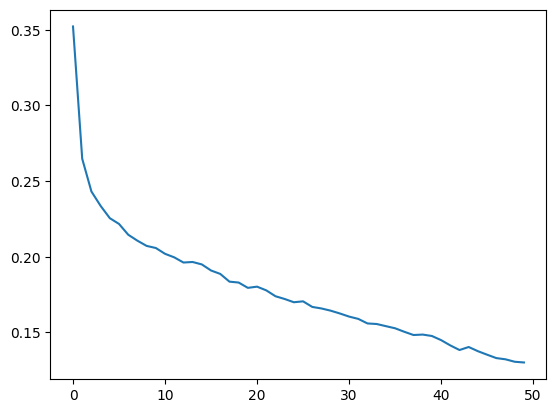

In [9]:
import matplotlib.pyplot as plt
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(train_history)
plt.show()

[[ 0.30879157]
 [-1.01161558]
 [ 0.6137675 ]
 ...
 [-0.26563752]
 [ 1.31729152]
 [-0.27170238]] [[ 0.19050713]
 [-0.85968995]
 [ 1.503619  ]
 ...
 [-0.18519124]
 [ 1.098166  ]
 [-0.5330239 ]]


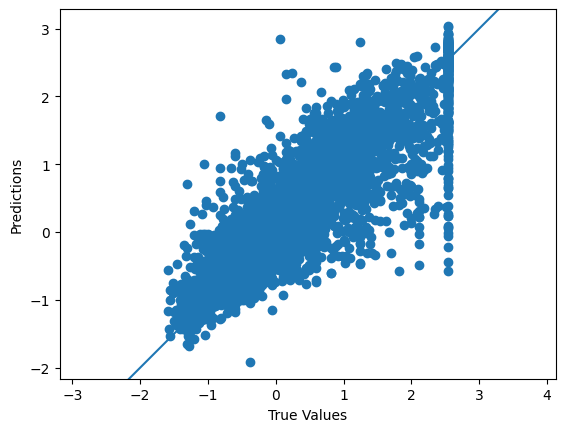

In [13]:
pred = housing_net(torch.from_numpy(X_test).float().to('cuda'))
pred = pred.cpu().detach().numpy()
plt.scatter(y_test, pred)
print(y_test, pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()

In [14]:
print(y_test[1], pred[1])

[-1.01161558] [-0.85968995]


In [15]:
label_scaler.inverse_transform([pred[1]])

array([[1.07535095]])

In [16]:
label_scaler.inverse_transform([y_test[1]])

array([[0.9]])